In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 32,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()(
    [pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21440/102124 [=====>........................] - ETA: 3:50 - loss: 0.1206 - acc: 0.9599

 64864/102124 [==================>...........] - ETA: 1:44 - loss: 0.0838 - acc: 0.9718

102112/102124 [============================>.] - ETA: 0s - loss: 0.0752 - acc: 0.9743

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0752 - acc: 0.9743 - val_loss: 0.0469 - val_acc: 0.9823
Epoch 2/32
 14016/102124 [===>..........................] - ETA: 4:09 - loss: 0.0553 - acc: 0.9797

102112/102124 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9798

102124/102124 [==============================] - 315s 3ms/step - loss: 0.0545 - acc: 0.9798 - val_loss: 0.0470 - val_acc: 0.9827
roc-auc: 0.9865 - roc-auc_val: 0.9843                                                                                                    
Epoch 3/32
  8704/102124 [=>............................] - ETA: 4:27 - loss: 0.0504 - acc: 0.9811

 61312/102124 [=================>............] - ETA: 1:55 - loss: 0.0504 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9812

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0502 - acc: 0.9812 - val_loss: 0.0435 - val_acc: 0.9835
Epoch 4/32
 10176/102124 [=>............................] - ETA: 4:22 - loss: 0.0484 - acc: 0.9813

 58400/102124 [================>.............] - ETA: 2:05 - loss: 0.0479 - acc: 0.9817

102112/102124 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9817

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0480 - acc: 0.9817 - val_loss: 0.0427 - val_acc: 0.9839
roc-auc: 0.9894 - roc-auc_val: 0.9864                                                                                                    
Epoch 5/32
  8704/102124 [=>............................] - ETA: 4:22 - loss: 0.0431 - acc: 0.9828

 54592/102124 [===============>..............] - ETA: 2:16 - loss: 0.0466 - acc: 0.9821

 97856/102124 [===========================>..] - ETA: 12s - loss: 0.0465 - acc: 0.9821

102124/102124 [==============================] - 325s 3ms/step - loss: 0.0465 - acc: 0.9821 - val_loss: 0.0414 - val_acc: 0.9837
Epoch 6/32
 12448/102124 [==>...........................] - ETA: 4:19 - loss: 0.0459 - acc: 0.9824

 60896/102124 [================>.............] - ETA: 1:58 - loss: 0.0456 - acc: 0.9824

 98048/102124 [===========================>..] - ETA: 11s - loss: 0.0453 - acc: 0.9826

102124/102124 [==============================] - 325s 3ms/step - loss: 0.0452 - acc: 0.9826 - val_loss: 0.0433 - val_acc: 0.9836
roc-auc: 0.9905 - roc-auc_val: 0.9878                                                                                                    
Epoch 7/32
  7776/102124 [=>............................] - ETA: 4:32 - loss: 0.0464 - acc: 0.9820

 50368/102124 [=============>................] - ETA: 2:26 - loss: 0.0441 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9830

102124/102124 [==============================] - 318s 3ms/step - loss: 0.0441 - acc: 0.9830 - val_loss: 0.0434 - val_acc: 0.9840

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002679433673620224.
Epoch 8/32
  8064/102124 [=>............................] - ETA: 4:22 - loss: 0.0434 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9831

102124/102124 [==============================] - 316s 3ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0405 - val_acc: 0.9844
roc-auc: 0.9913 - roc-auc_val: 0.9877                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 4:24 - loss: 0.0447 - acc: 0.9823

 53600/102124 [==============>...............] - ETA: 2:15 - loss: 0.0434 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9832

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0431 - acc: 0.9832 - val_loss: 0.0419 - val_acc: 0.9843
Epoch 10/32
 10144/102124 [=>............................] - ETA: 4:10 - loss: 0.0434 - acc: 0.9830

 48064/102124 [=============>................] - ETA: 2:31 - loss: 0.0424 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9835

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0423 - acc: 0.9835 - val_loss: 0.0426 - val_acc: 0.9838
roc-auc: 0.9921 - roc-auc_val: 0.988                                                                                                    
Epoch 11/32
  8736/102124 [=>............................] - ETA: 4:22 - loss: 0.0450 - acc: 0.9818

 74048/102124 [====================>.........] - ETA: 1:18 - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0420 - acc: 0.9836 - val_loss: 0.0420 - val_acc: 0.9840
Epoch 12/32
  3360/102124 [..............................] - ETA: 4:38 - loss: 0.0416 - acc: 0.9837

 44512/102124 [============>.................] - ETA: 2:40 - loss: 0.0417 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9838

102124/102124 [==============================] - 316s 3ms/step - loss: 0.0415 - acc: 0.9838 - val_loss: 0.0425 - val_acc: 0.9842
roc-auc: 0.9921 - roc-auc_val: 0.9874                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 4:14 - loss: 0.0426 - acc: 0.9834

101152/102124 [============================>.] - ETA: 2s - loss: 0.0411 - acc: 0.9841

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0411 - acc: 0.9840 - val_loss: 0.0402 - val_acc: 0.9846
Epoch 14/32
 13536/102124 [==>...........................] - ETA: 4:11 - loss: 0.0408 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9841

102124/102124 [==============================] - 319s 3ms/step - loss: 0.0406 - acc: 0.9841 - val_loss: 0.0416 - val_acc: 0.9845
roc-auc: 0.9925 - roc-auc_val: 0.9877                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 4:25 - loss: 0.0426 - acc: 0.9831

 47808/102124 [=============>................] - ETA: 2:32 - loss: 0.0403 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9841

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0406 - acc: 0.9841 - val_loss: 0.0411 - val_acc: 0.9845
Epoch 16/32
 10144/102124 [=>............................] - ETA: 4:21 - loss: 0.0393 - acc: 0.9843

 67552/102124 [==================>...........] - ETA: 1:37 - loss: 0.0399 - acc: 0.9845

102124/102124 [==============================] - 318s 3ms/step - loss: 0.0403 - acc: 0.9843 - val_loss: 0.0405 - val_acc: 0.9844
roc-auc: 0.9928 - roc-auc_val: 0.9881                                                                                                    
Epoch 17/32
   512/102124 [..............................] - ETA: 4:42 - loss: 0.0369 - acc: 0.9847

 48864/102124 [=============>................] - ETA: 2:29 - loss: 0.0399 - acc: 0.9843

 90432/102124 [=========================>....] - ETA: 32s - loss: 0.0402 - acc: 0.9841

102124/102124 [==============================] - 315s 3ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0407 - val_acc: 0.9848
Epoch 18/32
  9536/102124 [=>............................] - ETA: 4:18 - loss: 0.0384 - acc: 0.9851

 99136/102124 [============================>.] - ETA: 8s - loss: 0.0400 - acc: 0.9843

102124/102124 [==============================] - 316s 3ms/step - loss: 0.0399 - acc: 0.9843 - val_loss: 0.0413 - val_acc: 0.9844

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9929 - roc-auc_val: 0.988                                                                                                    
Epoch 19/32
  6560/102124 [>.............................] - ETA: 4:24 - loss: 0.0392 - acc: 0.9844

 44864/102124 [============>.................] - ETA: 2:42 - loss: 0.0401 - acc: 0.9841

 92256/102124 [==========================>...] - ETA: 27s - loss: 0.0396 - acc: 0.9845

102124/102124 [==============================] - 320s 3ms/step - loss: 0.0397 - acc: 0.9844 - val_loss: 0.0406 - val_acc: 0.9844
Epoch 20/32
 10272/102124 [==>...........................] - ETA: 4:23 - loss: 0.0414 - acc: 0.9837

 67424/102124 [==================>...........] - ETA: 1:38 - loss: 0.0399 - acc: 0.9843

102124/102124 [==============================] - 319s 3ms/step - loss: 0.0395 - acc: 0.9845 - val_loss: 0.0405 - val_acc: 0.9846
roc-auc: 0.9932 - roc-auc_val: 0.9883                                                                                                    
Epoch 21/32
   480/102124 [..............................] - ETA: 4:52 - loss: 0.0403 - acc: 0.9861

 86624/102124 [========================>.....] - ETA: 43s - loss: 0.0391 - acc: 0.9846

102124/102124 [==============================] - 318s 3ms/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0408 - val_acc: 0.9845
Epoch 22/32
  8128/102124 [=>............................] - ETA: 4:27 - loss: 0.0383 - acc: 0.9846

 66752/102124 [==================>...........] - ETA: 1:40 - loss: 0.0387 - acc: 0.9848

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0413 - val_acc: 0.9844
roc-auc: 0.9932 - roc-auc_val: 0.9883                                                                                                    
Epoch 23/32
   352/102124 [..............................] - ETA: 4:49 - loss: 0.0465 - acc: 0.9820

 62848/102124 [=================>............] - ETA: 1:51 - loss: 0.0391 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9846

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0390 - acc: 0.9846 - val_loss: 0.0411 - val_acc: 0.9845


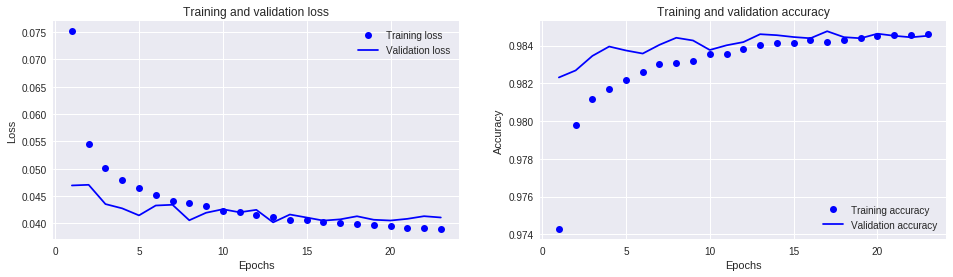

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 42s 1ms/step
([0.03951281232229131, 0.9846937045639405], 0.9899653658195308)
